In [7]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [16:42:31] Enabling RDKit 2019.09.3 jupyter extensions


# Getting a set of known ligands

let's pick some interesting receptor, and find substances that are known to be active on said receptor.
Use any resources you prefer. If you have a receptor/target that is of particular interest to you because of your other work, feel free to choose that one.

A good freely available resource for activity data is the [ChEMBL database](https://www.ebi.ac.uk/chembl/), targets are listed [here](https://www.ebi.ac.uk/chembl/g/#browse/targets). Unless you have any other particular preferences, pick one present in humans, preferably with hundreds of known agonists or inhibitors. Good gauges of activity are [EC50 values](https://en.wikipedia.org/wiki/EC50) and [IC50 values](https://en.wikipedia.org/wiki/IC50) respectively, though [other](https://en.wikipedia.org/wiki/Potency_(pharmacology)) or just [pChEMBL](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/chembl-data-questions#what-is-pchembl) will do too. A simple way to get to the good stuff is to select some target of clinical significance, as they tend to have large amount of associated activity values.

I picked [mTOR inhibitors](https://en.wikipedia.org/wiki/MTOR#mTOR_inhibitors_as_therapies), you pick yours, there are many to choose from: any from [steroid receptors](https://en.wikipedia.org/wiki/Steroid_hormone_receptor), [cannabinoid receptors](https://en.wikipedia.org/wiki/Cannabinoid_receptor), [opioid receptors](https://en.wikipedia.org/wiki/Opioid_receptor), [cyclooxygenases](https://en.wikipedia.org/wiki/Cyclooxygenase), [HMGCR](https://en.wikipedia.org/wiki/HMG-CoA_reductase), [histamine receptor](https://en.wikipedia.org/wiki/H1_receptor), or really anything else with enough ligands, the receptorome is your oyster :)

Let's search ChEMBL for your target of choice, I will continue with the mTOR:
https://www.ebi.ac.uk/chembl/g/#search_results/all/query=mTOR
, and let's go with the first one, a human variant with plenty of IC50 measurements:
https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL2842/
Under the Activity Charts are some nice pie graphs, select the most relevant activity segment. In this mTOR case, let's get the inhibitors from the IC50 value segment. Over 4000 is plenty. As long as there are more than 100 activities it should be fine for this workshop, of course the more the merrier.
https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/target_chembl_id%3ACHEMBL2842%20AND%20standard_type%3A(%22IC50%22)
Clicking the pie chart segment will forward you to the list of activities of the given type. Quick way to obtain them is the "Select All" option followed by Download CSV on the right. Download the file, extract it, rename it something sane, put it into your work folder and you are good to go.

# Processing the obtained ligand set

In [8]:
# let's have a look at the csv:
import csv
with open('Cytochrome_P450_targets.csv', 'r') as csvfile: # for you it will probably be just open('filename.csv', 'r')
    reader = csv.DictReader(csvfile, delimiter=";") # gotcha, it's delimited by ; despite being called a CSV
    rawdata = [x for x in reader] # a list of rows within the csv
rawdata[0] # peek at the first element, just to get an idea what they look like.
#reader returns ordered dictionaries, one for each row

OrderedDict([('Molecule ChEMBL ID', 'CHEMBL3109802'),
             ('Molecule Name', 'TBA-7371'),
             ('Molecule Max Phase', '2'),
             ('Molecular Weight', '355.40'),
             ('#RO5 Violations', '0'),
             ('AlogP', '1.22'),
             ('Compound Key', '12'),
             ('Smiles', 'COc1ncnc(Cn2cc(C(=O)NCCO)c3ncc(C)cc32)c1C'),
             ('Standard Type', 'IC50'),
             ('Standard Relation', "'>'"),
             ('Standard Value', '50000.0'),
             ('Standard Units', 'nM'),
             ('pChEMBL Value', ''),
             ('Data Validity Comment', ''),
             ('Comment', ''),
             ('Uo Units', 'UO_0000065'),
             ('Ligand Efficiency BEI', ''),
             ('Ligand Efficiency LE', ''),
             ('Ligand Efficiency LLE', ''),
             ('Ligand Efficiency SEI', ''),
             ('Potential Duplicate', 'True'),
             ('Assay ChEMBL ID', 'CHEMBL3292128'),
             ('Assay Description', 'Inhibition o

There are many different values, though we are for now interested in two things only: IDs and structures of known ligands. IDS are in the "Molecule ChEMBL ID" column, and structures are encoded within the "Smiles" column, in the [SMILES format](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system), which you probably already know from the lectures.

In [9]:
print(rawdata[0]['Molecule ChEMBL ID']) # getting first substance ID
print(rawdata[0]['Smiles']) # getting first substance structure in SMILES

CHEMBL3109802
COc1ncnc(Cn2cc(C(=O)NCCO)c3ncc(C)cc32)c1C


Now that we made some sense of the data, let's create RDKit molecule instances from the SMILES strings. Maybe just put the generated RDKit molecule instances as a new entry in the already existing dictionaries, or create separate lists. You can do whatever you feel most comfortable with. I will do the lists here, so the C-family guys can get a bit of respite from all the Pythonisms :)

In [10]:
ligand_ids = [m['Molecule ChEMBL ID'] for m in rawdata]
ligand_mols = [Chem.MolFromSmiles(m['Smiles']) for m in rawdata]
# the two lists are aligned, so that the ids and the associated structures are in the same order
len(ligand_ids), len(ligand_mols) # sizes are the same, good

(5841, 5841)

In [11]:
[x for x in ligand_mols if not x] # no empty value in the RDKit molecule instance list, so they all parsed ok

[]

Let's redo the ring count from the first lecture on our shiny new dataset:

In [12]:
ligand_rings = [Chem.GetSSSR(ligand) for ligand in ligand_mols]
ligand_rings[0] # have a look at ring count of the first molecule

3

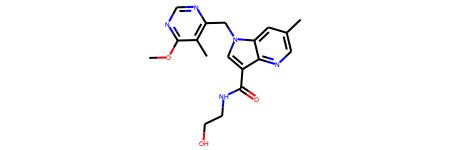

In [13]:
ligand_mols[0]

four rings indeed. Seems legit :) Let's find the average ring counts:

In [14]:
sum(ligand_rings)/len(ligand_mols)

3.781373052559493

3.78 rings on average is known for Cytochrome P450 inhibitors. In comparison, the average for drugs in DrugBank was 2.46, that's quite a difference. Any theories on why that might be?

Answer: The drugbank database can be full of antibodies, proteins or unorganic compounds, I havent checked it is just an idea.

# The takeaways
1. Pick a target, get a set of known ligands to that target. Familiarize yourself a bit with ChEMBL.
2. Download the csv, parse the data into Python, have look at them.
3. Create RDKit Mol instances from the SMILES within the data. Verify that you have parsed all molecules succesfully. If there are only few individual structures that refuse to parse (i.e. return None instead of Mol instance), discard them. If there is a problem in many structures, something is rotten. Upload both the dataset and the notebook anyway so we can have a look at it.
4. Compute the aforedescribed SSSR for your own dataset. How does your set's average ring count compare to 4.67 of this mTOR set, and to the 2.46 of DrugBank?
5. Put both the csv and your notebook into your work folder and push to this github repository. Have a look how others did it. Compare/comment?